In [240]:
reset -fs

In [241]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import warnings
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA

In [242]:
#grid order search based on BIC

def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m_values, D=1): #added m_values
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                for m in m_values:
                                    order=(p,d,q)
                                    seasonal_order=(P,D,Q,m)
                                    try:
                                        res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                        bic = res.bic
                                        if bic < best_score:
                                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                    except:
                                        continue
    print((best_score, best_order, best_seasonal_order))

In [243]:
# trend and seasonal differencing

def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

In [1]:
# different evaluation methods for SARIMA

def evaluate_sarima(X, trend_order, seasonal_order, score='rmse'):
    train_size = int(len(X) * 0.67)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
    # calculate out of sample error
    if score == 'mae':
        return mean_absolute_error(test, predictions)
    elif score == 'rmse':
        return sqrt(mean_squared_error(test, predictions))
    elif score == 'mape':
        return mean_absolute_percentage_error(test, predictions)

In [245]:
# define rmse to evaluate ETS models

def evaluate_es_model(X, Trend, Seasonal, m, damped=True, score='rmse'):
    train_size = int(len(X) * 0.67)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ExponentialSmoothing(history, trend=Trend, seasonal=Seasonal, seasonal_periods=m, damped=damped)
        res = model.fit()
        yhat = res.forecast()[0] #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
    # calculate out of sample error
    if score == 'mae':
        return mean_absolute_error(test, predictions)
    elif score == 'rmse':
        return sqrt(mean_squared_error(test, predictions))
    elif score == 'mape':
        return mean_absolute_percentage_error(test, predictions)

In [247]:
# Import the data

dt = pd.read_csv('zillow-carlifornia.csv', index_col='Date', parse_dates=True, squeeze=True)
dt = dt.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
train = dt[:'2015-12-31']
extra = dt['2016-01-31':]  # not contain MedianSoldPrice values and used for prediction

In [248]:
train.tail()

,MedianSoldPrice,MedianMortageRate,UnemploymentRate
Date,,,
2015-08-31,475000.0,3.95,5.2
2015-09-30,470000.0,3.87,5.1
2015-10-31,470000.0,3.80,5.0
2015-11-30,485750.0,3.69,5.0
2015-12-31,485000.0,3.89,5.1


In [249]:
# load the test data

test = pd.read_csv('test.csv', index_col='Month', parse_dates=True, squeeze=True)
test = test.rename("MedianSoldPrice") 

### Plots of original data

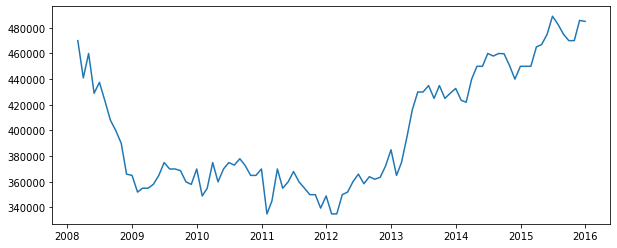

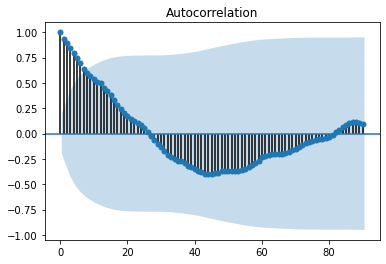

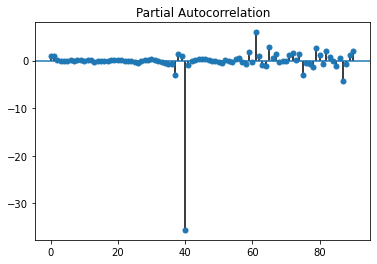

In [250]:
plt.figure(figsize=(10, 4))

plt.plot(train['MedianSoldPrice'])
plt.show()
plot_acf(train['MedianSoldPrice'], lags=90) 
plt.show()
plot_pacf(train['MedianSoldPrice'], lags=90) 
plt.show()


Original plot and ACF plot show there is trend and seasonality so the data will have to be differenced twice. The original curves shows the seasonality pattern repeats at m = 12

In [251]:
# Perform the ADF test to see if the data is stationary

dftest = adfuller(train['MedianSoldPrice'])
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


Since the p-values is > 0.05, ADF test shows that original series is not stationary.

### Difference the data - 1st time

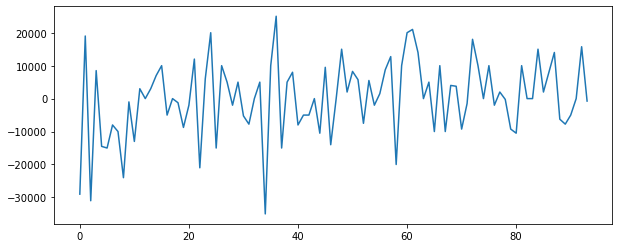

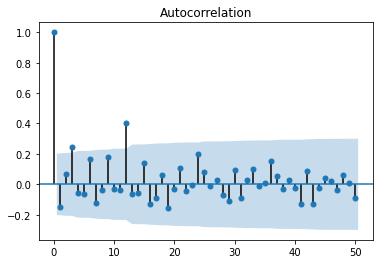

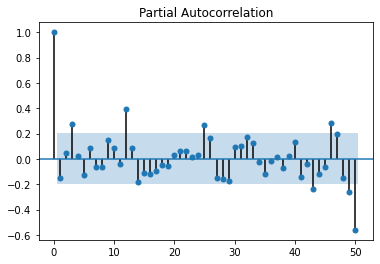

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


In [252]:
# do first difference of original data

X_train = train['MedianSoldPrice']
history_d1 = diff(X_train, 1)

plt.figure(figsize=(10, 4))

plt.plot(history_d1)
plt.show()
plot_acf(history_d1,lags=50) 
plt.show()
plot_pacf(history_d1,lags=50) 
plt.show()

dftest = adfuller(history_d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

The first-differenced data is still not stationary, need to difference it again.

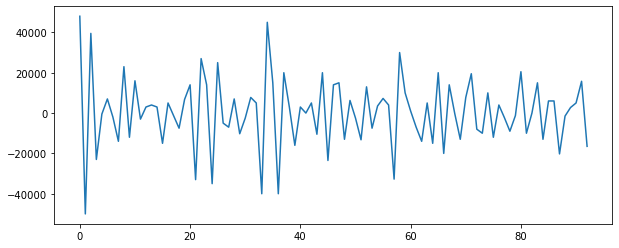

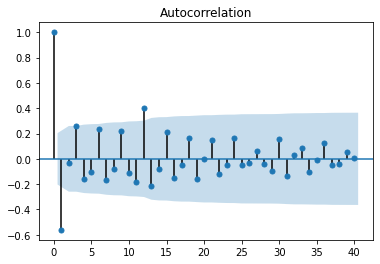

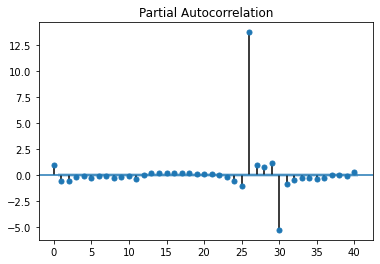

Test Statistic   -7.390432e+00
p-value           8.027576e-11
dtype: float64


In [253]:
# do second difference of original data

history_d2 = diff(history_d1, 1)

plt.figure(figsize=(10, 4))

plt.plot(history_d2)
plt.show()
plot_acf(history_d2,lags=40) 
plt.show()
plot_pacf(history_d2,lags=40) 
plt.show()

dftest = adfuller(history_d2)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

The second-differenced data is stationary, so we fix d as 2.  

## SARIMA

In [63]:
train an SARIMA model 
m_values = [3, 12]
d_values = [2]
p_values = range(6)
q_values = range(6)
Q_values = range(6)
P_values = range(6)
bic_sarima(X_train, p_values, d_values, q_values, P_values, Q_values, m_values, D=1)

In [ ]:
train an SARIMA model 
m_values = [3]
d_values = [2]
p_values = range(6)
q_values = range(6)
Q_values = range(6)
P_values = range(6)
bic_sarima(X_train, p_values, d_values, q_values, P_values, Q_values, m_values, D=1)

In [549]:
# Evaluate the model performance by cross validation with split rate = 0.67

rmse1 = evaluate_sarima(X_train, (0, 2, 2), (0, 1, 5, 3))
print(rmse1)

12361.983791096322


In [550]:
# Evaluate the model performance by cross validation with split rate = 0.67

rmse2 = evaluate_sarima(X_train, (0, 2, 5), (0, 1, 5, 12))
print(rmse2)

13976.356352117306


### candidate 1: SARIMA(0, 2, 5), (0, 1, 5, 12)

#### Train the model on the history data and use the validation set to check the rmse for future predictions

In [254]:
dt = pd.read_csv('zillow-carlifornia.csv', index_col='Date', parse_dates=True, squeeze=True)
dt = dt.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
history = dt[:'2015-12-31']

validation_date = '2014-12-31'
train = history[history.index <= validation_date]
valid = history[history.index > validation_date]

In [256]:
model_sarima = sm.tsa.statespace.SARIMAX(train['MedianSoldPrice'], order=(0, 2, 5), seasonal_order=(0, 1, 5, 12))
res = model_sarima.fit()
pred_sarima = res.predict(start=len(X_train),end=len(X_train)+len(valid)-1)
pred_sarima.index = valid.index
sqrt(mean_squared_error(valid['MedianSoldPrice'], pred_sarima))

26205.94602069833

##### Plot the actual vs forecast predictions for validation set

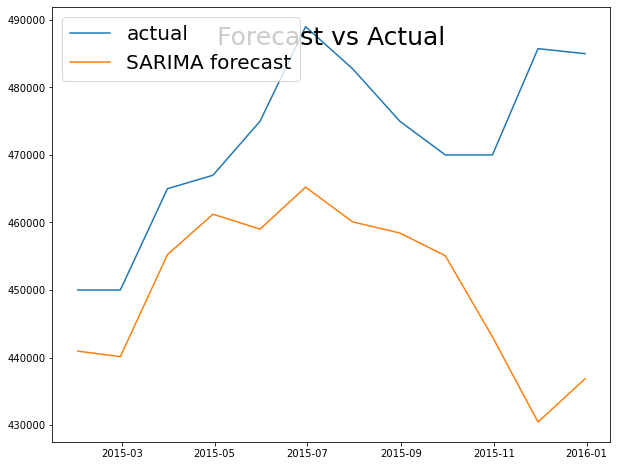

In [257]:
plt.figure(figsize=(10, 8))

plt.plot(valid['MedianSoldPrice'], label='actual')
plt.plot(pred_sarima, label='SARIMA forecast')
plt.legend(loc='upper left', fontsize=20)
plt.title('Forecast vs Actual', fontsize = 25, y = 0.9)
plt.show();

## ETS

In [15]:
# Fit different models with m=12

X = np.array(train.MedianSoldPrice)
ets_rmse_1_12 = evaluate_es_model(train.MedianSoldPrice, 
                                  Trend="additive", Seasonal="additive", m=12, damped=True)
ets_rmse_2_12 = evaluate_es_model(train.MedianSoldPrice, 
                                  Trend="additive", Seasonal='multiplicative', m=12, damped=True)

In [16]:
print(ets_rmse_1_12)
print(ets_rmse_2_12)

10905.321743635363
9830.411140441971


In [35]:
# MAPE for models with m=12

X = np.array(train.MedianSoldPrice)
ets_mape_1_12 = evaluate_es_model(train.MedianSoldPrice, Trend="additive", 
                                  Seasonal="additive", m=12, damped=True, score='mape')
ets_mape_2_12 = evaluate_es_model(train.MedianSoldPrice, Trend="additive", 
                                  Seasonal='multiplicative', m=12, damped=True, score='mape')

In [36]:
print(ets_mape_1_12, ets_mape_2_12)

0.019123006800050246 0.016780861469730325


#### Pick the best model and check the predictions - Trend="additive", Seasonal="additive", m=12

#### Train the model on the history data and use the validation set to check the rmse for future predictions

In [262]:
dt = pd.read_csv('zillow-carlifornia.csv', index_col='Date', parse_dates=True, squeeze=True)
dt = dt.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
history = dt[:'2015-12-31']

validation_date = '2014-12-31'
train = history[history.index <= validation_date]
valid = history[history.index > validation_date]

In [266]:
model_ses = ExponentialSmoothing(train.MedianSoldPrice, trend='additive', seasonal='multiplicative', seasonal_periods=12, damped=True)
fit_ses = model_ses.fit()
pred_ses = fit_ses.forecast(len(valid))
pred_ses.index = valid.index

##### Plot the actual vs forecast predictions for validation set

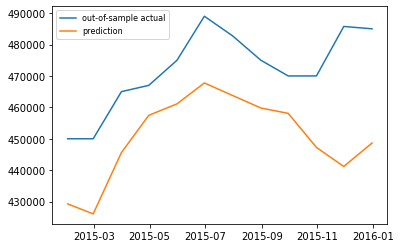

In [267]:
# draw the plot "out-of-sample actual" and "prediction" together.
plt.plot(valid['MedianSoldPrice'], label='out-of-sample actual')
plt.plot(pred_ses, label='prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [268]:
# evaluate model on test set
sqrt(mean_squared_error(valid['MedianSoldPrice'], pred_ses))

23576.18676668109

### Candidate 2: ETS model with Trend="additive", Seasonal="additive", m=12. RMSE for validation set: 23576.1867

## Univariate Prophet

In [273]:
from fbprophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [22]:
data = pd.read_csv('zillow-carlifornia.csv')
data = data.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
data = data[data.Date<='2015-12-31']
history = data[['Date', 'MedianSoldPrice']]
history = history.rename(columns={"Date": "ds", "MedianSoldPrice":"y"})
history.head()

,ds,y
0,2008-02-29,470000.0
1,2008-03-31,441000.0
2,2008-04-30,460000.0
3,2008-05-31,429000.0
4,2008-06-30,437500.0


In [274]:
data = pd.read_csv('zillow-carlifornia.csv')
data = data.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
data = data[data.Date<='2015-12-31']
history = data[['Date', 'MedianSoldPrice']]
history = history.rename(columns={"Date": "ds", "MedianSoldPrice":"y"})
validation_date = '2014-12-31'
train = history[history.ds <= validation_date]
valid = history[history.ds > validation_date]

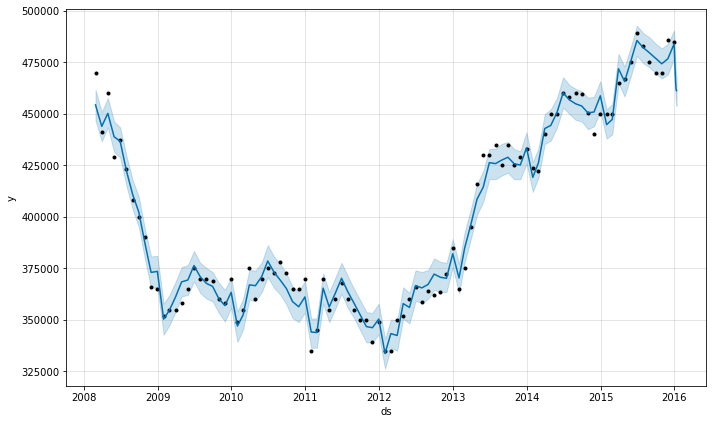

In [275]:
m = Prophet()
m.fit(history)
future = m.make_future_dataframe(periods=len(valid))
forecast = m.predict(future)
m.plot(forecast);

In [276]:
pred_prophet = forecast['yhat'][len(history):]
pred_prophet.index = valid.index

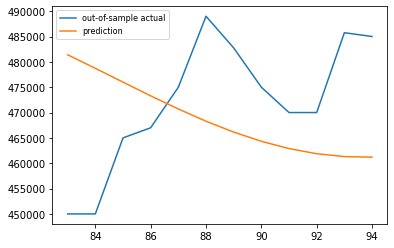

In [278]:
# draw the plot "out-of-sample actual" and "prediction" together.
plt.plot(valid.y, label='out-of-sample actual')
plt.plot(pred_prophet, label='prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [279]:
# evaluate model on test set
sqrt(mean_squared_error(valid.y, pred_prophet))

18460.03387193145

### Candidate 3: Prophet with RMSE for validation as 18460.0338

## Multivariate Prophet with one regressor

In [280]:
df = pd.read_csv('zillow-carlifornia.csv', index_col='Date',parse_dates=True, squeeze=True)

In [281]:
data = pd.read_csv('zillow-carlifornia.csv')
data = data.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
data = data[data.Date<='2015-12-31']
history = data[['Date', 'MedianSoldPrice']]
history = history.rename(columns={"Date": "ds", "MedianSoldPrice":"y"})
history.head()

,ds,y
0,2008-02-29,470000.0
1,2008-03-31,441000.0
2,2008-04-30,460000.0
3,2008-05-31,429000.0
4,2008-06-30,437500.0


In [282]:
train_prophet = data
train_prophet['mortage_rate'] = data['MedianMortageRate']
train_prophet['ds'] = data.Date
train_prophet['y'] = data['MedianSoldPrice']
train_prophet.index = data.Date

### split the training set to train and valid set

In [354]:
history = pd.read_csv('zillow-carlifornia.csv')
history = history.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
history = history[history.Date<='2015-12-31']
#history = data[['Date', 'MedianSoldPrice']]
history = history.rename(columns={"Date": "ds", "MedianSoldPrice":"y"})
history.head()

,ds,y,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [355]:
validation_date = '2014-12-31'
train = history[history.ds <= validation_date]
valid = history[history.ds > validation_date]

In [356]:
train_prophet = train
train_prophet['mortage_rate'] = train['MedianMortageRate']
train_prophet['ds'] = train.ds
train_prophet['y'] = train['y']
train_prophet.index = train.ds

In [357]:
mul_prophet_model = Prophet()
mul_prophet_model.add_regressor('mortage_rate')
mul_prophet_model.fit(train_prophet)

In [358]:
valid_prophet = pd.DataFrame()
valid_prophet['mortage_rate'] = valid['MedianMortageRate']
valid_prophet['ds'] = valid.ds
valid_prophet['y'] = valid['y']
valid_prophet.index = valid.ds

In [359]:
future = mul_prophet_model.make_future_dataframe(periods=12) 
future['ds'] = history.ds

In [360]:
future['mortage_rate'] = history.MedianMortageRate
forecast = mul_prophet_model.predict(future)
predictions = forecast['yhat'].values[-len(valid_prophet):]
predictions = pd.Series(predictions, index=valid.ds)

#predictions.index = valid.ds

In [361]:
sqrt(mean_squared_error(y_true=valid.y, y_pred=predictions))

7257.674601117478

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


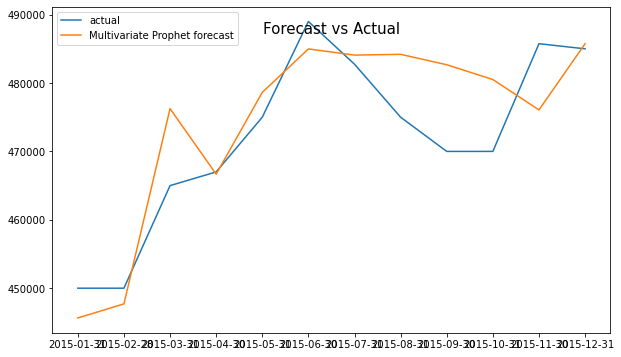

In [362]:
y_valid_series = pd.Series(valid.y.values, index=valid.ds)
plt.figure(figsize=(10, 6))
plt.plot(y_valid_series, label='actual')
plt.plot(predictions, label='Multivariate Prophet forecast')
plt.legend(loc='upper left', fontsize=10)
plt.title('Forecast vs Actual', fontsize = 15, y = 0.9)
plt.show();

### Candidate 4: Prophet with 1 regressor - MedianMortageRate with rmse 7257.6746 for validation set

## SARIMAX

In [341]:
dt = pd.read_csv('zillow-carlifornia.csv', index_col='Date', parse_dates=True, squeeze=True)
dt = dt.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
history = dt[:'2015-12-31']

validation_date = '2014-12-31'
train = history[history.index <= validation_date]
valid = history[history.index > validation_date]

In [342]:
# scale data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_sc = sc.fit_transform(train)
valid_sc = sc.transform(valid)

In [343]:
from pmdarima.arima import auto_arima

In [344]:
#auto sarimax search with m=12
model_sarimax = auto_arima(train_sc[:, 0], # MedianSoldPrice consumption as endogenous
                 exogenous = train_sc[:,1:], # MedianMortageRate, UnemploymentRate as exogenous variables
                 start_p=0, start_q=0, 
                 max_p=5, max_q=5, 
                 max_d=2,
                 trace=True, seasonal=True, D=1, m=12, max_P=3, max_Q=3, #add seasonality
                 error_action='ignore', 
                 suppress_warnings=True, information_criterion='oob', n_jobs = -1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-143.805, Time=0.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-144.310, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-146.007, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-144.577, Time=0.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-146.026, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-146.906, Time=0.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=-145.564, Time=0.62 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=-145.589, Time=0.77 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=-143.608, Time=0.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-143.634, Time=0.28 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=-152.524, Time=0.36 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-149.634, Time=0.15 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=-151.825, Time=0.59 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=-151.875, Time=1.27 sec
 ARIMA(2,1,0)(1,1,0

In [346]:
y_valid = model_sarimax.predict(n_periods=len(valid_sc), X=valid_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_valid, 3, axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0] # inverset the duplicated y_pred and get the last colomn as result

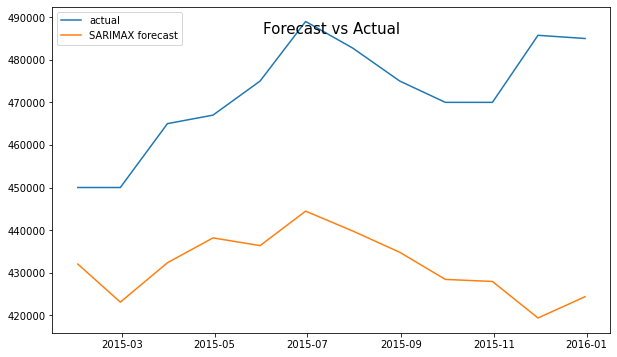

In [352]:
y_pred_series = pd.Series(y_pred_inv, index=valid.index)
plt.figure(figsize=(10, 6))
plt.plot(valid.MedianSoldPrice, label='actual')
plt.plot(y_pred_series, label='SARIMAX forecast')
plt.legend(loc='upper left', fontsize=10)
plt.title('Forecast vs Actual', fontsize = 15, y = 0.9)
plt.show()

In [198]:
# evaluate model on valid set
sqrt(mean_squared_error(validation.MedianSoldPrice, y_pred_inv))

42303.21849641789

### Candidate 5: SARIMAX (4,1,0)(0,1,2)[12] with rmse as 42303.2185 for validation set.

## LSTM

In [363]:
dt = pd.read_csv('zillow-carlifornia.csv', index_col='Date', parse_dates=True, squeeze=True)
dt = dt.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
history = dt[:'2015-12-31']

validation_date = '2014-12-31'
train = history[history.index <= validation_date]
valid = history[history.index > validation_date]

In [364]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

In [365]:
values = train.values  # y, x1, x2
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(values)
scaled_valid = sc.transform(valid)

In [366]:
reframed_train = series_to_supervised(scaled_train, 1, 1) 
reframed_valid = series_to_supervised(scaled_valid, 1, 1) 
print(reframed_train.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   1.000000   0.729927   0.200000  0.785185  0.784672  0.171429
2   0.785185   0.784672   0.171429  0.925926  0.777372  0.228571
3   0.925926   0.777372   0.228571  0.696296  0.795620  0.200000
4   0.696296   0.795620   0.200000  0.759259  0.843066  0.171429
5   0.759259   0.843066   0.171429  0.651852  0.956204  0.000000


In [367]:
# drop column we don't want to predict
reframed_train.drop(reframed_train.columns[[4, 5]], axis=1, inplace=True)
reframed_valid.drop(reframed_valid.columns[[4, 5]], axis=1, inplace=True)
print(reframed_train.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   1.000000   0.729927   0.200000  0.785185
2   0.785185   0.784672   0.171429  0.925926
3   0.925926   0.777372   0.228571  0.696296
4   0.696296   0.795620   0.200000  0.759259
5   0.759259   0.843066   0.171429  0.651852


In [368]:
reframed_train_values = reframed_train.values
reframed_valid_values = reframed_valid.values

# split into input and outputs
train_X, train_y = reframed_train_values[:, :-1], reframed_train_values[:, -1]
valid_X, valid_y = reframed_valid_values[:, :-1], reframed_valid_values[:, -1]

In [369]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(82, 1, 3) (82,) (11, 1, 3) (11,)


In [376]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# design network
model = Sequential()
model.add(LSTM(4, 
               input_shape=(train_X.shape[1], train_X.shape[2]))) # the 4 is the number of hidden layers/neurons, proportional to the sample size
model.add(Dense(1)) #final fully-connected (dense) layer, optional
model.compile(loss='mae')

In [377]:
history = model.fit(train_X, 
                    train_y, 
                    epochs=150, 
                    batch_size=12, verbose=0)

In [378]:
from numpy import concatenate

# make a prediction
yhat = model.predict(valid_X)
valid_X_2d = valid_X.reshape((valid_X.shape[0], valid_X.shape[2]))   # y(t-1), x1(t-1), x2(t-1)

In [379]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, valid_X_2d[:, 1:]), axis=1)   #  y(t)_pred, x1(t-1), x2(t-1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]   # y_pred (transform inverted) 

In [380]:
# invert scaling for actual
valid_y_2d = valid_y.reshape((len(valid_y), 1))
inv_y = concatenate((valid_y_2d, valid_X_2d[:, 1:]), axis=1)   #  y(t)_actual, x1(t-1), x2(t-1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]        # y(t)_actual

In [381]:
# evaluate model on test set
sqrt(mean_squared_error(inv_y, inv_yhat))

14133.32020589999

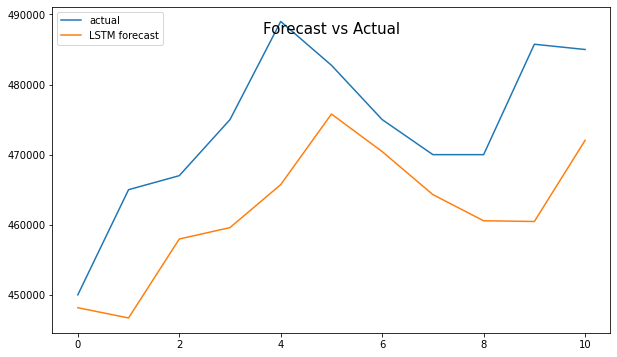

In [383]:
plt.figure(figsize=(10, 6))
plt.plot(inv_y, label='actual')
plt.plot(inv_yhat, label='LSTM forecast')
plt.legend(loc='upper left', fontsize=10)
plt.title('Forecast vs Actual', fontsize = 15, y = 0.9)
plt.show()

### Candidate 6: LSTM with RMSE as 14133.3202 for validation set

## Pick the final model and train the model on history data and check RMSE for test set

### Based on RMSE on validation set for all candidate models, the mutivariate Prophet with regressor 'MedianMortageRate' as the best model.

In [402]:
data = pd.read_csv('zillow-carlifornia.csv')
data = data.rename(columns={"MedianSoldPrice_AllHomes.California": "MedianSoldPrice"})
train = data[data.Date<='2015-12-31']
extra = data[data.Date>'2015-12-31']

history = data[['Date', 'MedianSoldPrice']]
history = history.rename(columns={"Date": "ds", "MedianSoldPrice":"y"})
history.tail()

,ds,y
102,2016-08-31,NaN
103,2016-09-30,NaN
104,2016-10-31,NaN
105,2016-11-30,NaN
106,2016-12-31,NaN


In [403]:
train_prophet = train
train_prophet['mortage_rate'] = train['MedianMortageRate']
train_prophet['ds'] = train.Date
train_prophet['y'] = train['MedianSoldPrice']
train_prophet.index = train.Date

In [404]:
train_prophet

,Date,MedianSoldPrice,MedianMortageRate,UnemploymentRate,mortage_rate,ds,y
Date,,,,,,,
2008-02-29,2008-02-29,470000.0,5.29,6.3,5.29,2008-02-29,470000.0
2008-03-31,2008-03-31,441000.0,5.44,6.2,5.44,2008-03-31,441000.0
2008-04-30,2008-04-30,460000.0,5.42,6.4,5.42,2008-04-30,460000.0
2008-05-31,2008-05-31,429000.0,5.47,6.3,5.47,2008-05-31,429000.0
2008-06-30,2008-06-30,437500.0,5.60,6.2,5.60,2008-06-30,437500.0
...,...,...,...,...,...,...,...
2015-08-31,2015-08-31,475000.0,3.95,5.2,3.95,2015-08-31,475000.0
2015-09-30,2015-09-30,470000.0,3.87,5.1,3.87,2015-09-30,470000.0
2015-10-31,2015-10-31,470000.0,3.80,5.0,3.80,2015-10-31,470000.0


In [405]:
mul_prophet_model = Prophet()
mul_prophet_model.add_regressor('mortage_rate')
mul_prophet_model.fit(train_prophet)

In [406]:
test_prophet = pd.DataFrame()
test_prophet['mortage_rate'] = extra['MedianMortageRate']
test_prophet['ds'] = extra.index
test_prophet['y'] = extra['MedianSoldPrice']
test_prophet.index = extra.index

In [407]:
future = mul_prophet_model.make_future_dataframe(periods=12) 
future['ds'] = df.index

In [408]:
future['mortage_rate'] = data.MedianMortageRate
forecast = mul_prophet_model.predict(future)
predictions = forecast['yhat'].values[-len(test_prophet):]

In [413]:
# load the test set
test = pd.read_csv('test.csv', index_col='Month', parse_dates=True, squeeze=True)
test = test.rename("MedianSoldPrice") 

In [415]:
# RMSE score on test set
sqrt(mean_squared_error(y_true=test, y_pred=predictions))

9140.502251982854

### Plot for prediction of the test set data using the final model. The RMSE for test set is 9140.5022

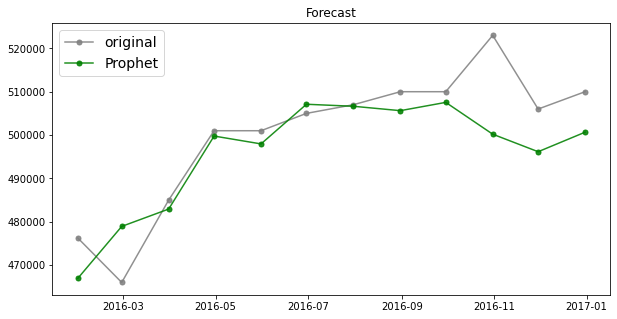

In [433]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test.index, test.values, 
        '-o', markersize=5, label='original', color='gray', alpha=0.87)
ax.plot(test.index.values, predictions, 
        '-o', markersize=5, label='Prophet', color='green', alpha=0.87)
ax.legend(loc='upper left', fontsize=14)

plt.title('Forecast')

plt.show()